<a href="https://colab.research.google.com/github/robLaing2/Forex_ANN_Forecasting/blob/master/ForexAnnEnvironment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting up Environment

In [69]:
%tensorflow_version 2.x

!pip install quandl
!pip install dbnomics
#!pip install FRB
!pip install fred
!pip install mock
#!pip uninstall tensorflow
#!pip install tensorflow==2.0.0

import fred
from mock import Mock
import requests
import json
import quandl
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Activation
from dbnomics import fetch_series
import pandas as pd
from keras.models import model_from_json
import matplotlib as mpl
import matplotlib.pyplot as plt



START_DATE = '2016-01-01'
END_DATE = ''

# Data Prepartion

## Pre-processing Interest Rate data


In [0]:
GBPovr = requests.get('https://api.stlouisfed.org/fred/series/observations?series_id=GBPONTD156N&api_key=cdc4dd9f1b0596f6209a77cec5453528&file_type=json&observation_start=' + START_DATE)
EURovr = requests.get('https://api.stlouisfed.org/fred/series/observations?series_id=EURONTD156N&api_key=cdc4dd9f1b0596f6209a77cec5453528&file_type=json&observation_start=' + START_DATE)
GBP1month = requests.get('https://api.stlouisfed.org/fred/series/observations?series_id=GBP1MTD156N&api_key=cdc4dd9f1b0596f6209a77cec5453528&file_type=json&observation_start=' + START_DATE)
EUR1month = requests.get('https://api.stlouisfed.org/fred/series/observations?series_id=EUR1MTD156N&api_key=cdc4dd9f1b0596f6209a77cec5453528&file_type=json&observation_start=' + START_DATE)
GBP3month = requests.get('https://api.stlouisfed.org/fred/series/observations?series_id=GBP3MTD156N&api_key=cdc4dd9f1b0596f6209a77cec5453528&file_type=json&observation_start='+ START_DATE)
EUR3month = requests.get('https://api.stlouisfed.org/fred/series/observations?series_id=EUR3MTD156N&api_key=cdc4dd9f1b0596f6209a77cec5453528&file_type=json&observation_start='+ START_DATE)
GBP6month = requests.get('https://api.stlouisfed.org/fred/series/observations?series_id=GBP6MTD156N&api_key=cdc4dd9f1b0596f6209a77cec5453528&file_type=json&observation_start='+ START_DATE)
EUR6month = requests.get('https://api.stlouisfed.org/fred/series/observations?series_id=EUR6MTD156N&api_key=cdc4dd9f1b0596f6209a77cec5453528&file_type=json&observation_start='+ START_DATE)
GBP12month = requests.get('https://api.stlouisfed.org/fred/series/observations?series_id=GBP12MD156N&api_key=cdc4dd9f1b0596f6209a77cec5453528&file_type=json&observation_start='+ START_DATE)
EUR12month = requests.get('https://api.stlouisfed.org/fred/series/observations?series_id=EUR12MD156N&api_key=cdc4dd9f1b0596f6209a77cec5453528&file_type=json&observation_start='+ START_DATE)

GBRovrJson = (json.loads(GBPovr.content))["observations"]
EURovrJson = (json.loads(EURovr.content))["observations"]
GBR1mJson = (json.loads(GBP1month.content))["observations"]
EUR1mJson = (json.loads(EUR1month.content))["observations"]
GBR3mJson = (json.loads(GBP3month.content))["observations"]
EUR3mJson = (json.loads(EUR3month.content))["observations"]
GBR6mJson = (json.loads(GBP6month.content))["observations"]
EUR6mJson = (json.loads(EUR6month.content))["observations"]
GBR12mJson = (json.loads(GBP12month.content))["observations"]
EUR12mJson = (json.loads(EUR12month.content))["observations"]

def getRatioValues(datasetX, datasetY):
    dates = []
    valuesX = []
    valuesY = []

    for x in range(len(datasetX)):
        if (datasetX[x]["value"] == '.' or datasetY[x]["value"] == '.'):
            continue

        dates.append(pd.Timestamp(datasetX[x]["date"]))
        valuesX.append(float(datasetX[x]["value"]))
        valuesY.append(float(datasetY[x]["value"]))

    datasetXarr = np.array(valuesX, dtype=np.float)
    datasetYarr = np.array(valuesY, dtype=np.float)

    ratioValues = datasetXarr / datasetYarr

    data_mean = ratioValues.mean()
    data_std = ratioValues.std()
    dataNormalised = (ratioValues - data_mean) / data_std

    res = {dates[i]: dataNormalised[i] for i in range(len(dates))}

    return res

GBPEURovrRatio = getRatioValues(GBRovrJson,EURovrJson)

GBPEUR1mRatio = getRatioValues(GBR1mJson,EUR1mJson)
GBPEUR3mRatio = getRatioValues(GBR3mJson,EUR3mJson)
GBPEUR6mRatio = getRatioValues(GBR6mJson,EUR6mJson)
GBPEUR12mRatio = getRatioValues(GBR12mJson,EUR12mJson)

## Pre-processing Inflation data

In [0]:
ukCPI = fetch_series('IMF/CPI/M.GB.PCPIHA_PC_CP_A_PT')
euCPI = fetch_series('IMF/CPI/M.U2.PCPIHA_PC_CP_A_PT')

dbnomicsQuery = "period >= '" + START_DATE + "'"

# and period < '2019-06-01'"

ukCPI = ukCPI.query(dbnomicsQuery)
euCPI = euCPI.query(dbnomicsQuery)

ukCPIdates = []
for x in ukCPI.period:
    ukCPIdates.append(x)

ukCPIarr = np.array(ukCPI.value, dtype=np.float)
euCPIarr = np.array(euCPI.value, dtype=np.float)

ukEuCpiRatio = ukCPIarr*1000 / euCPIarr*1000

# Normalise CPI data
cpi_mean = ukEuCpiRatio.mean()
cpi_std = ukEuCpiRatio.std()
ukEuCpiRatio = (ukEuCpiRatio - cpi_mean) / cpi_std

cpiDict = {ukCPIdates[i]: ukEuCpiRatio[i] for i in range(len(ukCPIdates))}

cpiData = {'Date':ukCPI.period, 'Value':ukEuCpiRatio}
cpiDf = pd.DataFrame(cpiData)

## Pre-processing International Reserves data

In [0]:
ukIR = fetch_series('IMF/IFS/M.GB.RAFAGOLDM_USD')
euIR = fetch_series('IMF/IFS/M.U2.RAFAGOLDM_USD')

dbnomicsQuery = "period >= '" + START_DATE + "'"
# and period < '2019-06-01'"

ukIR = ukIR.query(dbnomicsQuery)
euIR = euIR.query(dbnomicsQuery)

ukIRdates = []
for x in ukIR.period:
    ukIRdates.append(x)

ukIRarr = np.array(ukIR.value, dtype=np.float)
euIRarr = np.array(euIR.value, dtype=np.float)

ukEuIRRatio = ukIRarr*1000 / euIRarr*1000

ir_mean = ukEuIRRatio.mean()
ir_std = ukEuIRRatio.std()
ukEuIRRatio = (ukEuIRRatio - ir_mean) / ir_std

irDict = {ukIRdates[i]: ukEuIRRatio[i] for i in range(len(ukIRdates))}

irData = {'Date':ukIR.period, 'Value':ukEuIRRatio}
irDf = pd.DataFrame(irData)

## Pre-processing Balance of Payments data

In [0]:
ukBOP = fetch_series('IMF/BOP/Q.GB.BACK_BP6_USD')
euBOP = fetch_series('IMF/BOP/Q.U2.BACK_BP6_USD')

dbnomicsQuery = "period >= '" + START_DATE + "'"
# and period < '2019-06-01'"

ukBOP = ukBOP.query(dbnomicsQuery)
euBOP = euBOP.query(dbnomicsQuery)

ukBOPdates = []
for x in ukBOP.period:
    ukBOPdates.append(x)

ukBOParr = np.array(ukBOP.value, dtype=np.float)
euBOParr = np.array(euBOP.value, dtype=np.float)

ukEuBOPRatio = ukBOParr*1000 / euBOParr*1000

# Normalise BOP data
bop_mean = ukEuBOPRatio.mean()
bop_std = ukEuBOPRatio.std()
ukEuBOPRatio = (ukEuBOPRatio - bop_mean) / bop_std

bopDict = {ukBOPdates[i]: ukEuBOPRatio[i] for i in range(len(ukBOPdates))}

bopData = {'Date':ukBOP.period, 'Value':ukEuBOPRatio}
bopDf = pd.DataFrame(bopData)

print (bopDf)

          Date     Value
184 2016-01-01 -0.625983
185 2016-04-01  0.256890
186 2016-07-01 -0.010063
187 2016-10-01  0.888110
188 2017-01-01  0.341923
189 2017-04-01 -2.799623
190 2017-07-01  0.689791
191 2017-10-01  1.026453
192 2018-01-01  0.558607
193 2018-04-01  0.635569
194 2018-07-01  0.431774
195 2018-10-01  0.137063
196 2019-01-01 -0.781996
197 2019-04-01 -1.482463
198 2019-07-01  0.733947


## Pre-processing FOREX data


In [0]:
startDate = '2018-01-01'
endDate = '2019-01-01'

# Get FOREX data
quandl.ApiConfig.api_key = "VXqfuyrbTE8xxYZzqePw"
dataGbpEurRate = quandl.get("BOE/XUDLERS", start_date=START_DATE, returns="numpy")
forexDataN = dataGbpEurRate.Value

# Normalise data
forex_mean = forexDataN.mean()
forex_std = forexDataN.std()
forexDataN = (forexDataN - forex_mean) / forex_std

forexData = {'Date':dataGbpEurRate.Date,'Value':forexDataN}
forexDf = pd.DataFrame(forexData)

## FOREX Moving Averages

## Creating full data matrix

In [0]:
pd.set_option('display.max_rows', 12)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

mainDf = pd.DataFrame(columns=['Date','ForexRate','CPIRatio', 'IRRatio', 'BOPRatio', 'OvrLIBOR', '1mLIBOR','3mLIBOR','6mLIBOR','12mLIBOR'])

cpiCounter = 0
irCounter = 0

for index, row in forexDf.iterrows():

    newD = row['Date']
    roundD = newD.replace(day=1)
    quarterD = 1

    quarter = newD.quarter

    cpi = cpiDict.get(roundD,0)
    ir = irDict.get(roundD,0)

    switcher={
        1:newD.replace(month=1,day=1),
        2:newD.replace(month=4,day=1),
        3:newD.replace(month=7,day=1),
        4:newD.replace(month=10,day=1)
    }

    quarterD = switcher.get(newD.quarter)

    bop = bopDict.get(quarterD,0)

    ovrI = GBPEURovrRatio.get(row['Date'], 0)
    i1month = GBPEUR1mRatio.get(row['Date'], 0)
    i3month = GBPEUR3mRatio.get(row['Date'], 0)
    i6month = GBPEUR6mRatio.get(row['Date'], 0)
    i12month = GBPEUR12mRatio.get(row['Date'], 0)

    mainDf = mainDf.append({'Date':row['Date'],
                            'ForexRate':row['Value'],
                            'CPIRatio': cpi,
                            'IRRatio' : ir,
                            'BOPRatio': bop,
                            'OvrLIBOR': ovrI,
                            '1mLIBOR': i1month,
                            '3mLIBOR': i3month,
                            '6mLIBOR': i6month,
                            '12mLIBOR': i12month},
                            ignore_index=True)

print(mainDf)

# Split and format data
futureDistance = 0
historySize = 6

           Date  ForexRate  CPIRatio   IRRatio  BOPRatio  OvrLIBOR   1mLIBOR  \
0    2016-01-04  3.786610  -0.27492  -1.691234 -0.625983 -1.570888 -2.523949   
1    2016-01-05  3.905895  -0.27492  -1.691234 -0.625983 -1.576040 -2.489228   
2    2016-01-06  3.780930  -0.27492  -1.691234 -0.625983 -1.532770 -2.482512   
3    2016-01-07  3.510171  -0.27492  -1.691234 -0.625983 -1.511383 -2.426331   
4    2016-01-08  3.279174  -0.27492  -1.691234 -0.625983 -1.554221 -2.439148   
...         ...       ...       ...        ...       ...       ...       ...   
1051 2020-02-25  0.721165   0.00000   0.000000  0.000000 -0.278444 -0.179244   
1052 2020-02-26  0.548864   0.00000   0.000000  0.000000  0.000000  0.000000   
1053 2020-02-27  0.230769   0.00000   0.000000  0.000000  0.000000  0.000000   
1054 2020-02-28  0.060362   0.00000   0.000000  0.000000  0.000000  0.000000   
1055 2020-03-02 -0.272880   0.00000   0.000000  0.000000  0.000000  0.000000   

       3mLIBOR   6mLIBOR  12mLIBOR  
0 

# Models

## Standard ANN

In [0]:
from joblib import dump, load
import pickle



def formatData(data, start, end, history, target):
    x = []
    y = []
    
    startIndex = start + historySize
    endIndex = len(data) - futureDistance

    for i in range(startIndex, endIndex):
        indices = range(i-historySize, i)
        # Reshape data from (history_size,) to (history_size, 1)
        x.append(data[indices])
        y.append(data[i+futureDistance])
        
    return np.array(x), np.array(y)


TRAIN_SPLIT = round(len(forexDataN) * 0.7)
VALIDATION_SPLIT = round(len(forexDataN) * 0.85)

xTrain, yTrain = formatData(forexDataN, 0, TRAIN_SPLIT, historySize, futureDistance)
xVal, yVal = formatData(forexDataN, TRAIN_SPLIT, VALIDATION_SPLIT, historySize, futureDistance)
xTest, yTest = formatData(forexDataN, VALIDATION_SPLIT, None, historySize, futureDistance)

print(xTest[0])
print(yTest[0])

BATCH_SIZE = 30
BUFFER_SIZE = 10

# Form training tensors and shuffle etc.
dataTrain = tf.data.Dataset.from_tensor_slices((xTrain, yTrain))
dataTrain = dataTrain.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
# Form validation tensors and shuffle etc.
dataVal = tf.data.Dataset.from_tensor_slices((xVal, yVal))
dataVal = dataVal.batch(BATCH_SIZE).repeat()

# Create model
EVALUATION_INTERVAL = 10
EPOCHS = 2

def standard_ann_model():
	model = keras.Sequential([
        layers.Dense(6,input_dim=(6),kernel_initializer='normal',activation='relu'),
        layers.Dense(8, activation='relu'),
        layers.Dense(1)
    ])

	model.compile(optimizer='adam', loss='mse')
	return model


model = standard_ann_model()

model.fit(dataTrain, epochs=EPOCHS,
                    steps_per_epoch=EVALUATION_INTERVAL,
                    validation_data=dataVal,
                    validation_steps=50
          )


model.save('newmodel.h5')

result = model.evaluate(xTest, yTest, batch_size=30)
print("-----------------------------------------")
print("Model loss:", result)


#print(type(model))

## Univariate LSTM

In [37]:
def formatData(data, start, end, history, target):
    x = []
    y = []
    
    startIndex = start + historySize
    endIndex = len(data) - futureDistance

    for i in range(startIndex, endIndex):
        indices = range(i-historySize, i)
        # Reshape data from (history_size,) to (history_size, 1)
        x.append(np.reshape(data[indices], (historySize, 1)))
        y.append(data[i+futureDistance])
        
    return np.array(x), np.array(y)

TRAIN_SPLIT = round(len(forexDataN) * 0.7)
VALIDATION_SPLIT = round(len(forexDataN) * 0.85)

xTrain, yTrain = formatData(forexDataN, 0, TRAIN_SPLIT, historySize, futureDistance)
xVal, yVal = formatData(forexDataN, TRAIN_SPLIT, VALIDATION_SPLIT, historySize, futureDistance)
xTest, yTest = formatData(forexDataN, VALIDATION_SPLIT, None, historySize, futureDistance)

BATCH_SIZE = 30
BUFFER_SIZE = 10

# Form training tensors and shuffle etc.
dataTrain = tf.data.Dataset.from_tensor_slices((xTrain, yTrain))
dataTrain = dataTrain.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
# Form validation tensors and shuffle etc.
dataVal = tf.data.Dataset.from_tensor_slices((xVal, yVal))
dataVal = dataVal.batch(BATCH_SIZE).repeat()

# Create model
EVALUATION_INTERVAL = 100
EPOCHS = 10

def lstm_ann_model():
    lstm_model = keras.Sequential([
        layers.LSTM(8, input_shape=xTrain.shape[-2:]),
        layers.Dense(1)
    ])
    lstm_model.compile(optimizer='adam', loss='mse')
    return lstm_model

model = lstm_ann_model()

model.fit(dataTrain, epochs=EPOCHS,
                     steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=dataVal,
                      validation_steps=50)



result = model.evaluate(xTest, yTest, batch_size=30)
print("-----------------------------------------")
print("Model loss:", result)



Train for 100 steps, validate for 50 steps
Epoch 1/10
100/100 [==============================] - 2s 19ms/step - loss: 0.8461 - val_loss: 0.2081
Epoch 2/10
100/100 [==============================] - 0s 5ms/step - loss: 0.5417 - val_loss: 0.0934
Epoch 3/10
100/100 [==============================] - 0s 5ms/step - loss: 0.3097 - val_loss: 0.0788
Epoch 4/10
100/100 [==============================] - 1s 5ms/step - loss: 0.2012 - val_loss: 0.0815
Epoch 5/10
100/100 [==============================] - 0s 5ms/step - loss: 0.1405 - val_loss: 0.0783
Epoch 6/10
100/100 [==============================] - 0s 4ms/step - loss: 0.1051 - val_loss: 0.0726
Epoch 7/10
100/100 [==============================] - 0s 4ms/step - loss: 0.0748 - val_loss: 0.0659
Epoch 8/10
100/100 [==============================] - 0s 4ms/step - loss: 0.0738 - val_loss: 0.0600
Epoch 9/10
100/100 [==============================] - 0s 5ms/step - loss: 0.0659 - val_loss: 0.0544
Epoch 10/10
151/151 [==============================] - 0

## Multivariate LSTM (Single-step)

In [87]:


EPOCHS = 2
EVALUATION_INTERVAL = 10


features = ['ForexRate', 'CPIRatio', 'OvrLIBOR']

dataSet = mainDf[features]
dataSet.index = mainDf['Date']

dataSet = dataSet.values

TRAIN_SPLIT = round(len(dataSet) * 0.7)
VALIDATION_SPLIT = round(len(dataSet) * 0.85)

features = []
labels = []

def getData(dataSet,target,start,end,lags,targetSize,step):

    data = []
    labels = []

    start = start + lags
    end = end - futureDistance

    for i in range(start,end):
        indices = range(i-lags, i, step)
        data.append(dataSet[indices])
        labels.append(target[i+targetSize])

    return np.array(data), np.array(labels)

lags = 20
futureDistance = 10
step = 1

xTrain, yTrain = getData(dataSet, dataSet[:, 0], 0, TRAIN_SPLIT, lags, futureDistance, step)
xVal, yVal = getData(dataSet, dataSet[:, 0],TRAIN_SPLIT, VALIDATION_SPLIT, lags, futureDistance, step)
xTest, yTest = getData(dataSet, dataSet[:, 0],VALIDATION_SPLIT, len(dataSet), lags, futureDistance, step)

trainData = tf.data.Dataset.from_tensor_slices((xTrain, yTrain))
trainData = trainData.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

valData = tf.data.Dataset.from_tensor_slices((xVal, yVal))
valData = valData.batch(BATCH_SIZE).repeat()

def lstm_ann_single_model():
    lstm_model = keras.Sequential([
        layers.LSTM(32, input_shape=xTrain.shape[-2:]),
        layers.Dense(1)
    ])

    lstm_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mse')
    return lstm_model


model = lstm_ann_single_model()

single_step_history = model.fit(trainData, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=valData,
                                            validation_steps=50)



result = model.evaluate(xTest, yTest, batch_size=30)
print("-----------------------------------------")
print("Model loss:", result)


[ 3.78660992  3.9058953   3.78092966 ...  0.23076938  0.06036169
 -0.27288002]
Single window of past history : (20, 3)
Train for 10 steps, validate for 50 steps
Epoch 1/2
10/10 [==============================] - 2s 207ms/step - loss: 1.5994 - val_loss: 0.2157
Epoch 2/2
128/128 [==============================] - 0s 2ms/sample - loss: 0.1488
-----------------------------------------
Model loss: 0.14884640841046348


##Multivariate LSTM (Multi-step)

# Testing

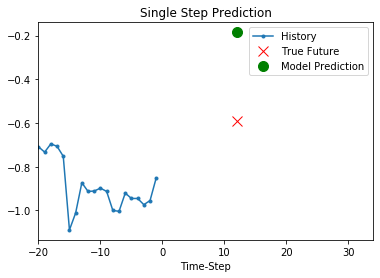

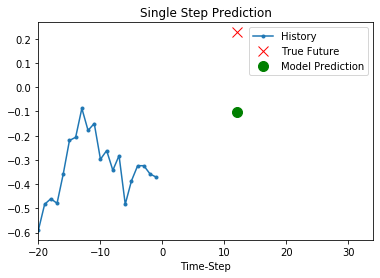

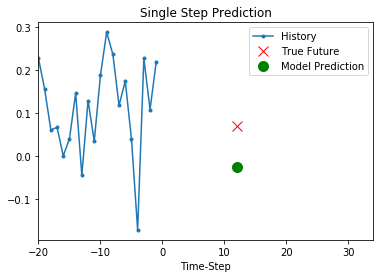

In [88]:
import matplotlib as mpl
import matplotlib.pyplot as plt


def create_time_steps(length):
  return list(range(-length, 0))

def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt


for x, y in valData.take(3):
  plot = show_plot([x[0][:, 0].numpy(), y[0].numpy(),
                    model.predict(x)[0]], 12,
                   'Single Step Prediction')
  plot.show()